## Sap2000를 이용한 캐비넷 지진해석 인풋 아웃풋 학습-예측모델
## D:\2020 전력기술원\나의과제\2023전력기술지\06_논문코드\data에 있음
### 인풋 15 아웃풋 15개 세트
### 4096 개 0.005초 간격

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

import argparse

import time
import datetime

from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr   
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from torch.autograd import Variable

import matplotlib.pyplot as plt
import os, glob

from torch.utils.data import Dataset, DataLoader

## Class 정리

In [2]:
class My_Dataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [3]:
class CNN(nn.Module):
    def __init__(self, data_length, numout):
        super(CNN, self).__init__()
        self.data_length = data_length
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU()
        )
        
        self.output_layer = nn.Sequential(nn.Linear(64,50),
                                          nn.ReLU(),
                                          nn.Linear(50,50),
                                          nn.ReLU(),
                                          nn.Linear(50, numout))
        
    def forward(self, x_in):
        x = x_in.permute(0,2,1)
        x = self.conv(x)
        x = x[:, :, :self.data_length]
        x = x.permute(0,2,1)
        out = self.output_layer(x)
        return out

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, out_num):
        super().__init__()
        self.num_senseors = num_sensors # number of featurers
        self.hidden_units = hidden_units
        self.num_layers = 1
        
        self.lstm = nn.LSTM(
            input_size = num_sensores,
            hidden_size = hidden_units,
            batch_first= True,
            num_layers= self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_feature=out_num)
        
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_seiz, self.hidden_units).requires_grad_()
        
        _,(hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])
        
        return out

In [6]:
class DeepPhyCNN:
    #initialize the class
    def __init__(self, output_y, input_x, Phi_t, learning_rate):
        super(DeepPhyCNN, self).__init__()
        
        self.output_y = output_y
        self.input_x = input_x
        self.Phi_t = Phi_t
        
        # output_y : target_train, input_x: input_train, Phit_t: Phi_t, learning_rate : 1e-3
        
        # torch and model
        self.learning_rate = learning_rate  #초기 학습률
        self.output_y = torch.from_numpy(output_y).float()
        self.input_x = torch.from_numpy(input_x).float()
        
        self.model = CNN(data_length = self.output_y.shape[1], numout = self.output_y.shape[2])
        
        self.output_y.requires_grad = True
        self.input_x.requires_grad = True
        
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        
    def net_structure(self, input_x):
        
        pred_y = self.model(input_x)
        
        Phi_ut = self.Phi_t.reshape(1, self.output_y.shape[1], self.output_y.shape[1])
        Phi_ut = Phi_ut.repeat(self.output_y.shape[0], axis=0)
        
        pred_y_reshape_velocity = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), pred_y)
        pred_y_reshape = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), pred_y_reshape_velocity)
        # 기존에 없던 코드 한줄 추가. eta_tt 를 예측하려면 Phi_ut x(Phi_ut x self.model(input_x))  
        
        return pred_y, pred_y_reshape
    
    # loss 합계
    def criterion(self, target_in, pred_y_phi_in, pred_in): 
        return torch.mean(torch.square(target_in - pred_y_phi_in)) + torch.mean(torch.square(pred_in[:,:,0:10]))
    
    def train(self, num_epochs, bfgs, batch_size = 64):
        Loss = []
        self.pred_y, self.pred_y_phi = self.net_structure(self.input_x)
        
        self.model.train()
        
        for epoch in range(num_epochs):
            N = self.output_y.shape[0]
            for it in range(0,N, batch_size):
                self.optimizer_Adam.zero_grad()
                self.pred_y, self.pred_y_phi = self.net_structure(self.input_x)
                loss = self.criterion(self.output_y, self.pred_y_phi, self.pred_y)
                loss.backward()
                self.optimizer_Adam.step()
                if it %(10*batch_size) == 0:
                    print('Epoch: %d, It: %d, Loss: %.3e, Learning Rate: %.3e'
                         %(epoch, it/batch_size, loss.item(), self.learning_rate))

            Loss.append(loss.item())   # tensor에서 값만 가지고 와서 LOSS에 추가
            
        if bfgs == 1:
            # use L-BFGS optimizer
            self.optimizer_lbfgs = optim.LBFGS(self.model.parameters(), lr=self.learning_rate, max_iter=10, max_eval=50000,
                                                history_size = 50, line_search_fn='strong_wolfe')
            def closure():
                self.optimizer_lbfgs.zero_grad()
                self.pred_y, self.pred_y_phi = self.net_structure(self.input_x)
                loss = self.criterion(self.output_y, self.pred_y_phi, self.pred_y)
                loss.backward()
                return loss
            
            self.optimizer_lbfgs.step(closure)
            
            print('LBFGS Loss :' , self.criterion(self.output_y, self.pred_y_phi, self.pred_y).item())
            Loss.append(self.criterion(self.output_y, self.pred_y_phi, self.pred_y).item())
            
        return Loss
    
    def predict(self, test_in):
        self.model.eval()
        test_in = torch.from_numpy(test_in).float()
        test_in.requires_grad = False
        
        _, pred_y_phi = self.net_structure(test_in)
        
        pred_y_phi = pred_y_phi.detach().numpy()
        
        return pred_y_phi
    

In [7]:
class Base_Model :
    # 순수 모델을 위한 초기 클래스
    
    def __init__(self, output_y, input_x, Phi_t, learning_rate, model= 'cnn'):
        super(Base_Model, self).__init__()
        
        self.output_y = output_y
        self.input_x = input_x
        self.Phi_t = Phi_t
        
        # placeholders for data
        self.learning_rate = learning_rate
        self.output_y = torch.from_numpy(self.output_y).float()
        self.input_x = torch.from_numpy(self.input_x).float()
        self.model_name = model
        self.model = CNN(data_length=self.output_y.shape[1], numout=self.output_y.shape[2]) if model== 'cnn' else \
                      LSTM(num_sensors=input_x.shape[-1], hidden_units=10, out_num=self.output_y.shape[1])
        
        self.output_y.requires_grad = True
        self.input_x.requires_grad = True
        
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def net_structure(self, input_x):
        
        pred_y = self.model(input_x)
        
        return pred_y
    
    
    def criterion(self, target_in, pred_in):
        
        return torch.mean(torch.square(target_in - pred_in))
    
    def run_train(self, num_epochs, bfgs, batch_size = 64):
        Loss = []
        
        self.pred_y = self.net_structure(self.input_x)
        self.model.train()
        
        for epoch in range(num_epochs):
            N = self.output_y.shape[0]
            
            for it in range(0, N, batch_size):
                self.optimizer_Adam.zero_grad()
                self.pred_y = self.net_structure(self.input_x)
                loss = self.criterion(self.output_y, self.pred_y)
                loss.backward()
                self.optimizer_Adam.step()
                if it % (10*batch_size) == 0:
                         print('Epoch: %d, It: %d, Loss: %.3e, Learning Rate: %.3e'
                         %(epoch, it/batch_size, loss.item(), self.learning_rate))
                        
            Loss.append(loss.item())
            
        if bfgs == 1:
            # use L-BFGS optimizer
            self.optimizer_lbfgs = optim.LBFGS(self.model.parameters(), lr=self.learning_rate, max_iter=10, max_eval=50000,
                                                history_size = 50, line_search_fn='strong_wolfe')
            def closure():
                self.optimizer_lbfgs.zero_grad()
                self.pred_y = self.net_structure(self.input_x)
                loss = self.criterion(self.output_y, self.pred_y)
                loss.backward()
                return loss
            
            self.optimizer_lbfgs.step(closure)
            
            print('LBFGS Loss :' , self.criterion(self.output_y, self.pred_y).item())
            Loss.append(self.criterion(self.output_y, self.pred_y).item())
            
        return Loss
    
    def predict(self, test_in):
        self.model.eval()
        test_in = torch.from_numpy(test_in).float()
        test_in.requires_grad = False
        
        test_pred = self.net_structure(test_in)
        
        test_pred = test_pred.detach().numpy()
        
        return test_pred
    

## 함수들(def)

In [27]:
def data_write(type_text,array, fn):
    
    if not os.path.isfile(fn):
        with open(fn, 'w') as f:
            f.write(type_text)
            f.write('\n')
            np.savetxt(f, array, delimiter=",")
    else:
        with open(fn, 'a') as f:
            f.write(type_text)
            f.write('\n')
            np.savetxt(f, array,delimiter=",")


In [11]:
def cal_phi(n, dt):
    # 유한차등법(foward finite difference, Derivative :1 , Accuracy :2 일때 -3/2, 2, -1/2)
    # df1.0/dx = (-1.5f1 + 2.0f2 - 0.5f3) / △x
    
    phi1 = np.concatenate([np.array([-3/2, 2. -1/2]), np.zeros([n-2, ])])
    temp1 = np.concatenate([-1/2 * np.identity(n-2), np.zeros([n-2, 2])], axis=1)
    temp2 = np.concatenate([np.zeros([n-2, 2]), 1/2 * np.identity(n-2)], axis=1)
    phi2 = temp1 + temp2
    phi3 = np.concatenate([np.zeros([n-3, ]), np.array([1/2, -2, 3/2])])
    
    Phi_t = 1 / dt * np.concatenate([np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
    
    return Phi_t

In [12]:
def set_data(data_path):
    output_dic = {}
    # glob :  데이터 디텍토리에 있는 모든 입력 및 출력 파일의 이름을 찾는 함수
    input_dataset = glob.glob(os.path.join(os.path.join(data_path+'/', 'input'), '*.txt'))
    output_dataset = glob.glob(os.path.join(os.path.join(data_path+'/', 'output'), '*.txt'))
    
    # pd.read_csv 함수를 사용하여 각 입력 및 출력 파일을 판다스 데이터프레임으로 읽습니다.
    # np.array :각 판다스 데이터프레임을 넘파이 배열로 전환
    input_dataset = np.array([pd.read_csv(input,header=None).values.astype(np.float64) for input in input_dataset])
    output_dataset = np.array([pd.read_csv(output,header=None).values.astype(np.float64) for output in output_dataset])
    
    # np.sqeeze : LSTM 출력 데이터 세트의 마지막 차원을 제거
    # np.reshape : 입력 및 출력 데이터 세트의 모양을 LSTM 모델에 맞게 변형
    # dict() : 입력, 출력 및 LSTM 출력 데이터 세트를 포함하는 사전 생성
    output_dic['lstm_output_dataset'] = np.squeeze(output_dataset)
    output_dic['input_dataset'] = input_dataset.reshape([input_dataset.shape[0], input_dataset.shape[1], 1]) if input_dataset.ndim==2 else input_dataset
    output_dic['output_dataset'] = output_dataset.reshape([output_dataset.shape[0], output_dataset].shape[1], 1) if output_dataset.ndim==2 else output_dataset
    
    return output_dic
    

In [13]:
def createFolder(directory):
    try :
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Make dir')
            return directory
        
        else :
            return directory
    except OSError :
        print('ERROR: Creating directory.' + directory)

## 데이터 전처리 시작

In [14]:
if __name__ =="__main__":
    
    parser = argparse.ArgumentParser(description='ag2utt forecast')
    parser.add_argument("--data_path", type=str, default = "D:/MHC/2022/개인자료/kmong/battery_health_등푸른비행선/지진값",
                         help="ag2utt data path")    
    parser.add_argument("--limit_len", type=int, default= 4096)
    parser.add_argument("--d_time", type=float, default=0.005)    
    parser.add_argument("--train_ratio", type=float, default=0.8)    
    parser.add_argument("--dof", type=int, default=0)
    args = parser.parse_args(args=[])
    
    dataDir = args.data_path
    
    dt = args.d_time
    
    train_ratio = args.train_ratio
    
    result_dir = createFolder(directory='./inference_result/')
    
    time_stamp = datetime.datetime.today().strftime("%Y%m%d_%H_%M_%S")
    
    dataset = set_data(data_path=dataDir)
    
    input_dataset = dataset['input_dataset']
    output_dataset = dataset['output_dataset']
    lstm_output_dataset = dataset['lstm_output_dataset']
    
    Phi_t = cal_phi(n=output_dataset.shape[1], dt=dt)
    Phi_t_lstm = cal_phi(n=output_dataset.shape[1], dt=dt)
    

Make dir


## Training Data

In [15]:
N_train = int(input_dataset.shape[0]*train_ratio)
# 15개 데이터 * 학습 비율 0.8

In [16]:
input_train = input_dataset[0:N_train]
target_train = output_dataset[0:N_train]
# lstm은 생략


In [38]:
#CNN
model = Base_Model(target_train, input_train, Phi_t, learning_rate=1e-3, model='cnn')

#PhyCNN
phycnn = DeepPhyCNN(target_train, input_train, Phi_t, learning_rate=1e-3)

# LOSS
phycnn_loss = phycnn.train(num_epochs=20, bfgs=1, batch_size=N_train)
cnn_loss = model.run_train(num_epochs=20, bfgs=1, batch_size=N_train)

Epoch: 0, It: 0, Loss: 1.217e+00, Learning Rate: 1.000e-03
Epoch: 1, It: 0, Loss: 3.720e-01, Learning Rate: 1.000e-03
Epoch: 2, It: 0, Loss: 3.331e-01, Learning Rate: 1.000e-03
Epoch: 3, It: 0, Loss: 3.028e-01, Learning Rate: 1.000e-03
Epoch: 4, It: 0, Loss: 2.574e-01, Learning Rate: 1.000e-03
Epoch: 5, It: 0, Loss: 2.028e-01, Learning Rate: 1.000e-03
Epoch: 6, It: 0, Loss: 2.161e-01, Learning Rate: 1.000e-03
Epoch: 7, It: 0, Loss: 2.193e-01, Learning Rate: 1.000e-03
Epoch: 8, It: 0, Loss: 1.635e-01, Learning Rate: 1.000e-03
Epoch: 9, It: 0, Loss: 1.496e-01, Learning Rate: 1.000e-03
Epoch: 10, It: 0, Loss: 1.423e-01, Learning Rate: 1.000e-03
Epoch: 11, It: 0, Loss: 1.377e-01, Learning Rate: 1.000e-03
Epoch: 12, It: 0, Loss: 1.326e-01, Learning Rate: 1.000e-03
Epoch: 13, It: 0, Loss: 1.287e-01, Learning Rate: 1.000e-03
Epoch: 14, It: 0, Loss: 1.265e-01, Learning Rate: 1.000e-03
Epoch: 15, It: 0, Loss: 1.206e-01, Learning Rate: 1.000e-03
Epoch: 16, It: 0, Loss: 1.170e-01, Learning Rate: 

<function matplotlib.pyplot.legend(*args, **kwargs)>

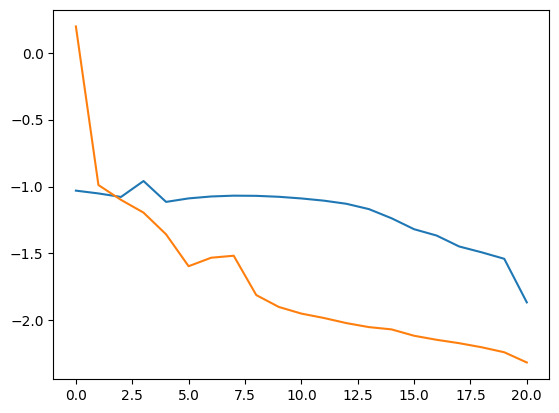

In [39]:
plt.figure()
plt.plot(np.log(cnn_loss), label='cnn_loss')
plt.plot(np.log(phycnn_loss), label='phycnn_loss')
plt.legend

### Prediction

In [40]:
input_test = input_dataset[N_train:]
target_test = output_dataset[N_train:]

In [41]:
input_test = input_test.reshape([input_test.shape[0], input_test.shape[1], 1]) if input_test.ndim ==2 else input_test
target_test = target_test.reshape([target_test.shape[0], target_test.shape[1], 1]) if target_test.ndim ==2 else target_test

In [42]:
model.output_y = target_test
phycnn.output_y = target_test

In [43]:
y_pred = model.predict(input_test)
y_pred_phy = phycnn.predict(input_test)

In [44]:
print(target_test.shape)
print(y_pred.shape)
print(y_pred_phy.shape)

(3, 4097, 1)
(3, 4097, 1)
(3, 4097, 1)


In [45]:
save_list = {'target': np.squeeze(target_test), 'cnn': np.squeeze(y_pred), 'phy_cnn': np.squeeze(y_pred_phy)}

fn= result_dir + f'inference_result_{time_stamp}.csv'

for k, v in save_list.items(): 
    print(k)
    data_write(type_text=k, array=v, fn=fn)

target
cnn
phy_cnn


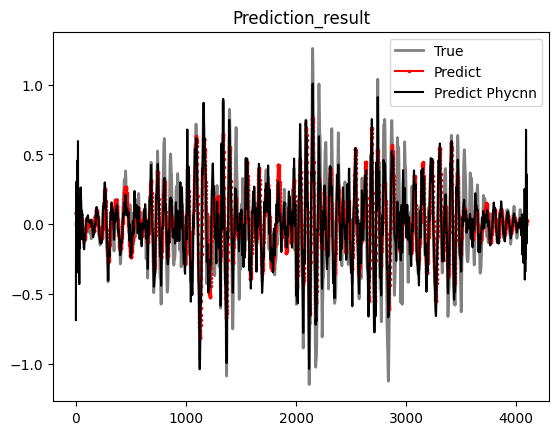

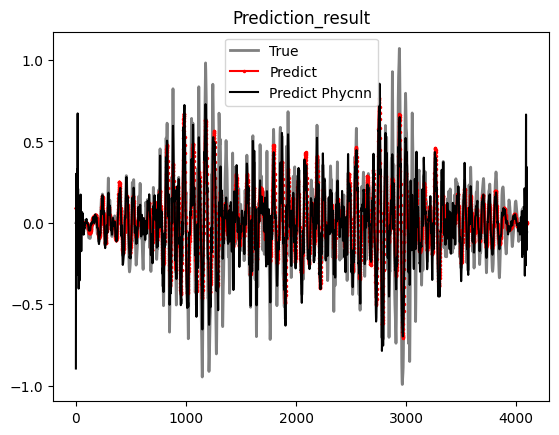

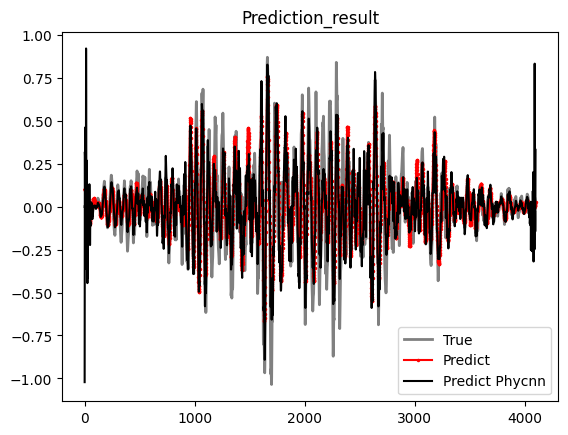

In [53]:
for ii in range(len(target_test)):
        plt.figure()
        plt.plot(target_test[ii, :, 0], 'gray',linewidth=2, label='True')
        plt.plot(y_pred[ii, :, 0], 'r.-', markersize=3, label='Predict')
        plt.plot(y_pred_phy[ii, :, 0], 'k-',  label='Predict Phycnn')
        plt.title('Prediction_result')
        plt.legend()

R_Phycnn = []
R2 = []

corr_list = []
corr_phy_list = []

In [54]:
for ii in range(len(target_test)):
    # reg1 = LinearRegression().fit(y_pred_ref[ii, :, 0:1], y_pred[ii, :, 0:1])
    r2 = r2_score(target_test[ii, :, 0:1],  y_pred[ii, :, 0:1])
    r_phy = r2_score(target_test[ii, :, 0:1],  y_pred_phy[ii, :, 0:1])

    corr = pearsonr(np.squeeze(target_test[ii, :, 0:1]),  np.squeeze(y_pred[ii, :, 0:1]))[0]

    corr_phy = pearsonr(np.squeeze(target_test[ii, :, 0:1]),  np.squeeze(y_pred_phy[ii, :, 0:1]))[0]

    R2.append(r2)
    R_Phycnn.append(r_phy)

    corr_list.append(corr)
    corr_phy_list.append(corr_phy)

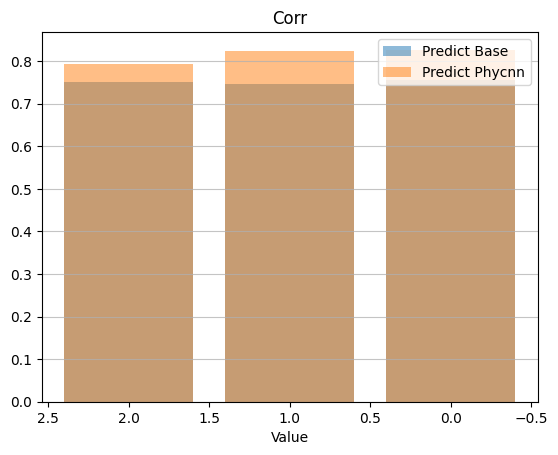

In [55]:
plt.figure()
plt.bar(range(len(corr_list)), corr_list,  alpha=0.5, label='Predict Base')
plt.bar(range(len(corr_phy_list)), corr_phy_list,  alpha=0.5, label='Predict Phycnn')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.title('Corr')
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.show()

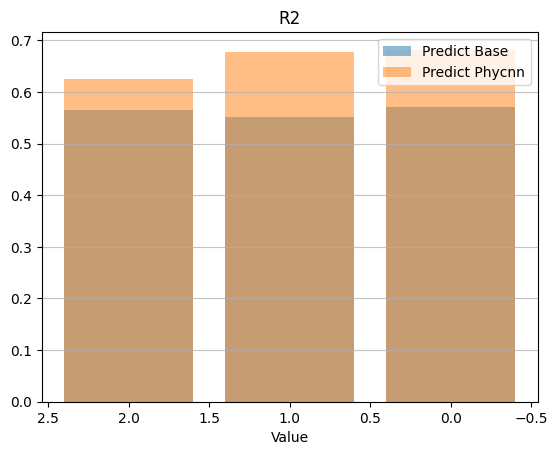

In [56]:
plt.figure()
plt.bar(range(len(R2)), R2,  alpha=0.5, label='Predict Base')
plt.bar(range(len(R_Phycnn)), R_Phycnn,  alpha=0.5, label='Predict Phycnn')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.title('R2')
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.show()